In [40]:
import tqdm as tqdm
import voicing as vc
from tqdm import tqdm
import importlib
import formats as fmt
import numpy as np
import json

In [58]:
#Load dataset

with open('../data/formatted/meta_dataset.txt', 'r') as jsonFile:
    meta_augmented = json.load(jsonFile)
    
with open('../data/formatted/dataset_augmented.txt', 'r') as jsonFile:
    dataset_augmented = json.load(jsonFile)
    
with open('../data/formatted/midi_voicing_dataset.txt', 'r') as jsonFile:
    midi_voicing_dataset = json.load(jsonFile)

print(len(midi_voicing_dataset), len(dataset_augmented), len(meta_augmented))

48072 48072 48072


- Fix the Style Token
- Split the songs that are too long into two sections

In [59]:

importlib.reload(fmt)
fmt.correctStyleTokensInMeta(meta_augmented)

all_styles = []
for song in meta_augmented:     
    all_styles.append(song['style'])

styles = set(all_styles)
print(len(styles))
print(meta_augmented[0])

# for i, song in enumerate(meta_augmented[:48]):
#     print(song)

  0%|          | 0/48072 [00:00<?, ?it/s]

63
{'composer': 'George Gershwin, Ira Gershwin (1927)', 'style': 'Jazz', 'song_name': "'S Wonderful", 'tonality': 'C major', 'midi_key': 15, 'time_signature': '4/4', 'decade': 'Null'}


In [60]:
#Add the tonality token to the dataset and to the midi_voicing_dataset
new_dataset = dataset_augmented.copy()
for i, song in enumerate(new_dataset):
    song[0] = ['Style', 0.0]
    midi_voicing_dataset[i][0] = [[0, 0, 0, 0, 0, 0, 0, 0], 0.0, 'Style']
    tonality = meta_augmented[i]['tonality']
    tonal_token = ['Tonality', 0.0]
    element_to_add = [tonality, 0.0]
    #add these two elements into the third position of the list
    song.insert(2, tonal_token)
    song.insert(3, element_to_add)
    
    midi_tonal_token = [[0, 0, 0, 0, 0, 0, 0, 0], 0.0, 'Tonality']
    element_to_add = [[0, 0, 0, 0, 0, 0, 0, 0], 0.0, tonality]
    midi_voicing_dataset[i].insert(2, midi_tonal_token)
    midi_voicing_dataset[i].insert(3, element_to_add)
    
print(len(new_dataset), len(midi_voicing_dataset))

48072 48072


In [61]:
#clean the sequence adding the duration element only after dot

importlib.reload(vc)
voicing = vc.Voicing()

print(len(new_dataset))
dataset = []
midi_dataset = []
for i, song in enumerate(tqdm(new_dataset)):
    sequence = []
    midi_sequence = []
    for j in range(1, len(song)):
        s = song[j][0]
        d = song[j][1]
        previous = song[j-1][0]
        m = midi_voicing_dataset[i][j][0]
        sequence.append(s)
        midi_sequence.append(m)
        if s == '.':
            sequence.append(d)
            midi_sequence.append(m)
    dataset.append(sequence)
    midi_dataset.append(midi_sequence)
            
print(len(dataset), len(midi_dataset))
            

48072


100%|██████████| 48072/48072 [00:36<00:00, 1330.43it/s]

48072 48072


In [36]:
id = 24768
print(dataset[id][:2048])

['Medium Shuffle', 'Tonality', 'C major', 'Form_intro', '|', '.', 1.0, 'C', 'maj', '.', 1.0, 'C', 'maj', '/', 'E', '.', 1.0, 'F', 'maj', '.', 1.0, 'F', 'maj', '/', 'A', '|', '.', 1.0, 'C', 'maj', '.', 1.0, 'C', 'maj', '/', 'E', '.', 1.0, 'F', 'maj', '.', 1.0, 'F', 'maj', '/', 'A', '|', '.', 1.0, 'C', 'maj', '.', 1.0, 'C', 'maj', '/', 'E', '.', 1.0, 'F', 'maj', '.', 1.0, 'F', 'maj', '/', 'G', '|', '.', 1.0, 'Ab', 'maj', '.', 1.0, 'Bb', 'maj', '.', 2.0, 'C', 'maj', 'Form_A', '|', '.', 1.0, 'C', 'maj', '.', 1.0, 'C', 'maj', '/', 'E', '.', 1.0, 'F', 'maj', '.', 1.0, 'F', 'maj', '/', 'A', '|', '.', 1.0, 'C', 'maj', '.', 1.0, 'C', 'maj', '/', 'E', '.', 1.0, 'F', 'maj', '.', 1.0, 'F', 'maj', '/', 'A', '|', '.', 1.0, 'C', 'maj', '.', 1.0, 'C', 'maj', '/', 'E', '.', 1.0, 'F', 'maj', '.', 1.0, 'F', 'maj', '/', 'G', '|', '.', 1.0, 'Ab', 'maj', '.', 1.0, 'Bb', 'maj', '.', 2.0, 'C', 'maj', '|', '.', 1.0, 'C', 'maj', '.', 1.0, 'C', 'maj', '/', 'E', '.', 1.0, 'F', 'maj', '.', 1.0, 'F', 'maj', '/', 'A

In [62]:
#Add Start and End token

for i, song in enumerate(dataset):
    start_token = '<start>'
    end_token = '<end>'
    song.insert(4, start_token)
    song.append(end_token)
    
print(len(dataset))

for i, song in enumerate(midi_dataset):
    start_token = [0, 0, 0, 0, 0, 0, 0, 0]
    end_token = [0, 0, 0, 0, 0, 0, 0, 0]
    song.insert(4, start_token)
    song.append(end_token)
    
print(len(midi_dataset))

48072
48072


In [63]:
#Cut the songs that are longer than 2048
dataset = [song[:2048] for song in dataset]
midi_dataset = [song[:2048] for song in midi_dataset]
print(len(dataset), len(midi_dataset))

for i, song in enumerate(dataset):
    if len(song) == 2048:
        element = song[-1]
       
        if element == '|' or element == '.' and element != '<end>':
            song[-1] = '<end>'
            midi_dataset[i][-1] = [0, 0, 0, 0, 0, 0, 0, 0]
        else:
        #cut the last element until it is a bar or dot and change it to <end>
            while element != '|' and element != '.':
                song.pop()
                midi_dataset[i].pop()
                element = song[-1]
            song[-1] = '<end>' 
            midi_dataset[i][-1] = [0, 0, 0, 0, 0, 0, 0, 0]   
                
id = 5676
print(len(dataset), len(midi_dataset))

print(dataset[id][-8:], midi_dataset[id][-8:]) 

48072 48072
48072 48072
[1.0, 'Bb', 'maj', '.', 1.0, 'F', 'maj', '<end>'] [[0, 0, 0, 0, 0, 0, 0, 0], [46, 0, 0, 0, 0, 0, 0, 0], [46, 53, 58, 62, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [53, 0, 0, 0, 0, 0, 0, 0], [53, 60, 65, 69, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0]]


In [34]:
id = 5676
print(len(dataset[id]))
dataset[id][-6:]

2046


[['maj', 2.0], ['.', 1.0], ['G', 1.0], ['m', 1.0], ['|', 1.0], ['<End>', 1.0]]

In [64]:
#Check the length of the song

max = {'v': 0, 'id': 0}
min = {'v': 1000, 'id': 0}

for i in range(len(midi_dataset)):
    if len(dataset[i]) > max['v']:
        max['v'] = len(dataset[i])
        max['id'] = i
    if len(dataset[i]) < min['v']:
        min['v'] = len(dataset[i])
        min['id'] = i

print('Max:', max, 'Min:', min)

#calculate how many songs are longer than 2048
counter = 0
lengths = []
for i, song in enumerate(dataset):
    if len(song) > 2048:
        counter += 1
        lengths.append(len(song))
print(counter, lengths)

Max: {'v': 2048, 'id': 3372} Min: {'v': 149, 'id': 39972}
0 []


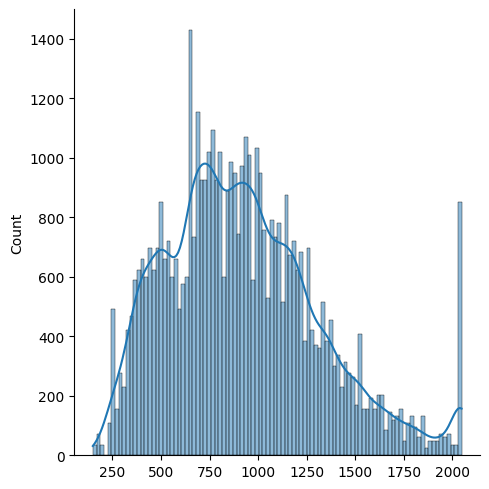

In [65]:
import seaborn as sns

#visualize the length of the songs

length = []
for song in dataset:
    length.append(len(song))
    
sns.displot(length, kde=True, bins=100)

In [66]:
print(dataset[0][:512])

['Medium Swing', 'Tonality', 'C major', '|', '<start>', '.', 4.0, 'C', 'maj', '|', '.', 4.0, 'C', 'maj', '|', '.', 4.0, 'C#', 'o', '|', '.', 4.0, 'C#', 'o', '|', '.', 4.0, 'D', 'm7', '|', '.', 4.0, 'G', 'dom7', '|', '.', 4.0, 'C', 'maj', '|', '.', 4.0, 'C', 'maj', '|', '.', 4.0, 'C', 'maj', '|', '.', 4.0, 'C', 'maj', '|', '.', 4.0, 'C#', 'o', '|', '.', 4.0, 'C#', 'o', '|', '.', 4.0, 'D', 'm7', '|', '.', 4.0, 'G', 'dom7', '|', '.', 4.0, 'C', 'maj', '|', '.', 2.0, 'F#', 'm7', '.', 2.0, 'B', 'dom7', '|', '.', 4.0, 'E', 'maj', '|', '.', 2.0, 'F#', 'm7', '.', 2.0, 'B', 'dom7', '|', '.', 4.0, 'E', 'maj', '|', '.', 2.0, 'F#', 'm7', '.', 2.0, 'B', 'dom7', '|', '.', 4.0, 'E', 'm7', '|', '.', 4.0, 'A', 'dom7', '|', '.', 4.0, 'D', 'dom7', '|', '.', 4.0, 'G', 'dom7', '|', '.', 4.0, 'C', 'maj', '|', '.', 4.0, 'C', 'maj', '|', '.', 4.0, 'Eb', 'o', '|', '.', 4.0, 'Eb', 'o', '|', '.', 4.0, 'D', 'm7', '|', '.', 4.0, 'G', 'dom7', '|', '.', 4.0, 'C', 'maj', '|', '.', 4.0, 'C', 'maj', '|', '|', '.', 4.0, 

In [77]:
#Cut the samples longer than 1024 in half and add them to the dataset
# fixed_dataset = []
# fixed_meta = []
# for i, song in enumerate(dataset):
#     if len(song) > 1024:
#         size = len(song)
#         half = size // 2
#         fixed_dataset.append(song[:half])
#         fixed_meta.append(meta_augmented[i])
#         new_section = song[half:]
#         fixed_dataset.append(new_section)
#         fixed_meta.append(meta_augmented[i])
#     else:
#         fixed_dataset.append(song)
#         fixed_meta.append(meta_augmented[i])

# print(len(fixed_dataset), len(fixed_meta)) 

56412 56412


In [78]:
# fixed_midi_dataset = []

# for i, song in enumerate(midi_dataset):
#     if len(song) > 1024:
#         size = len(song)
#         half = size // 2
#         fixed_midi_dataset.append(song[:half])
#         new_section = song[half:]
#         fixed_midi_dataset.append(new_section)
#     else:
#         fixed_midi_dataset.append(song)

# print(len(fixed_midi_dataset)) 

56412


In [67]:
#Add the <pad> token to the dataset and to the midi_voicing_dataset, max length is 1024
length = 2048

for i, song in enumerate(dataset):
    if len(song) < length:
        for j in range(length - len(song)):
            song.append('<pad>')

for i, song in enumerate(midi_dataset):
    if len(song) < length:
        for j in range(length - len(song)):
            song.append([0, 0, 0, 0, 0, 0, 0, 0])

print(len(dataset), len(midi_dataset))
    

48072 48072


In [68]:
import numpy as np
dataset = np.array(dataset, dtype=object)
midi_dataset = np.array(midi_dataset, dtype=object)
meta_augmented = np.array(meta_augmented, dtype=object)
print(dataset.shape, midi_dataset.shape, meta_augmented.shape)

#save the dataset
np.save('../data/formatted/dataset.npy', dataset)
np.save('../data/formatted/midi_dataset.npy', midi_dataset)
np.save('../data/formatted/meta_augmented.npy', meta_augmented)


(48072, 2048) (48072, 2048, 8) (48072,)
